## Todo
- ### Set this THING to RGB as a standerd 
- Get black objects
    - get all boxes 
    - cap them off by size
    - **OR**
    - get them by the HSV value
    - get all corners and create boxes search for black objects by size
- Test System Robustness (Meh?)

## Settings
- VM capture
    - Frame Size: 1024x768
    - Highest Qulity
- cospace Rescue 
    - Render -> Graphics Settings -> video Quailty -> Low

In [4]:
%matplotlib inline

import cv2
import time
import imutils
import PIL.Image
import numpy as np
import IPython.display
from pprint import pprint
import matplotlib.pyplot as plt

# set video quality to low 
#BGR not RGB
a=cv2.VideoCapture("good.webm") #btw the colors are inverted along the R and B
ret,frame=a.read()

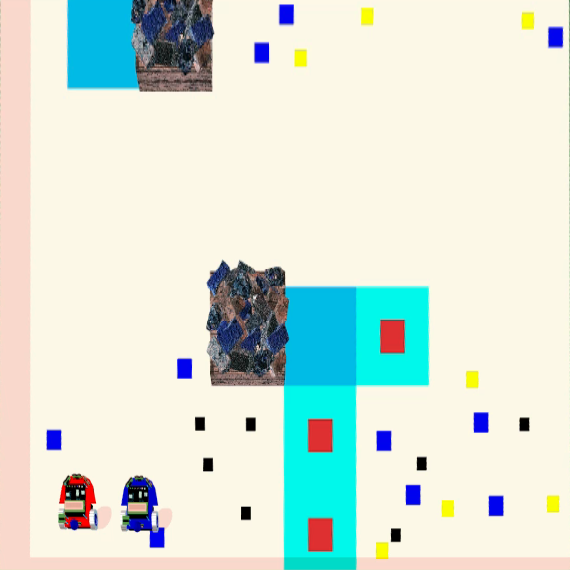

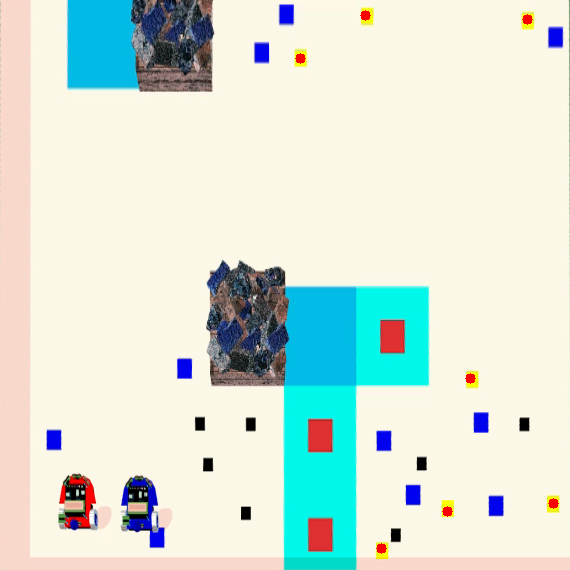

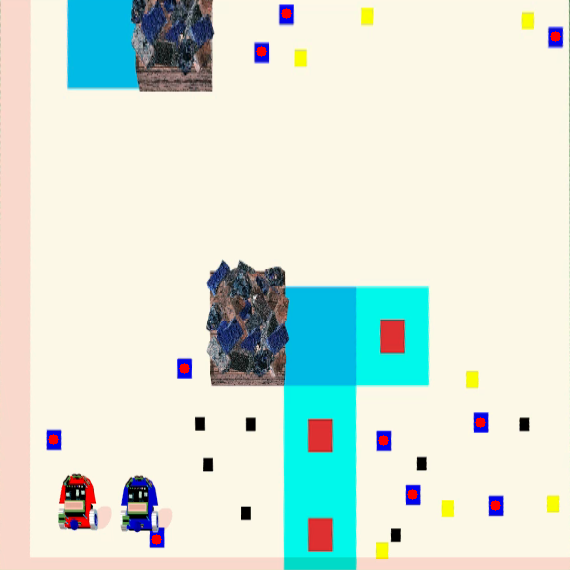

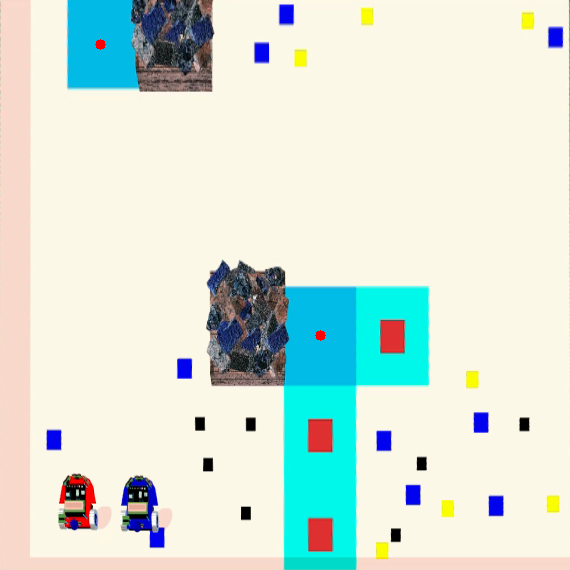

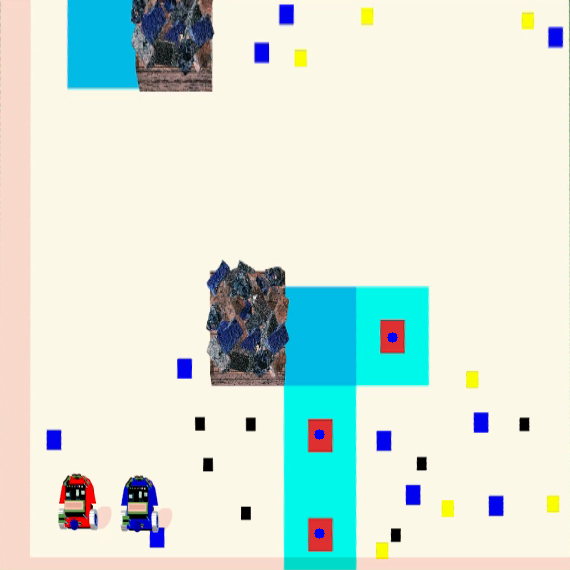

In [5]:
'''Make the camera Normal'''
pt_tl = [155,135]
pt_tr = [805,135]
pt_br = [940,625] # bottom right
pt_bl = [45,625] # bottom left
w,h=570,570

showarray(cam_norm(frame))

'''Detect Yellow Objects'''
frame=cam_norm(frame)
res,mask=get_color(frame,[255,255,0],[30,30,0])
viz_box(frame,get_box_cords(mask,7,50))

'''Detect Blue'''
res,mask=get_color(frame,[0,0,255],[0,0,10])
viz_box(frame,get_box_cords(mask,7,100))

'''Detect Deposit'''
res,mask=get_color(frame,[0, 188, 230],[0, 150, 200])
viz_box(frame,get_box_cords(mask,150,500))

'''Detect Traps!'''
res,mask=get_color(frame,[255,0,0],[10,0,0])
viz_box(frame,get_box_cords(mask,10,500),c=(0,0,255))

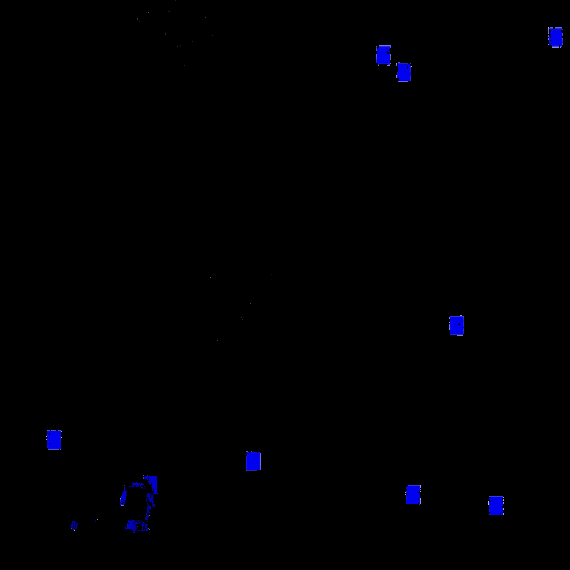

In [256]:
'''Get Blue Robot and Blue Objects'''
showarray(get_color(frame,[0,0,255],[0,0,30])[0])

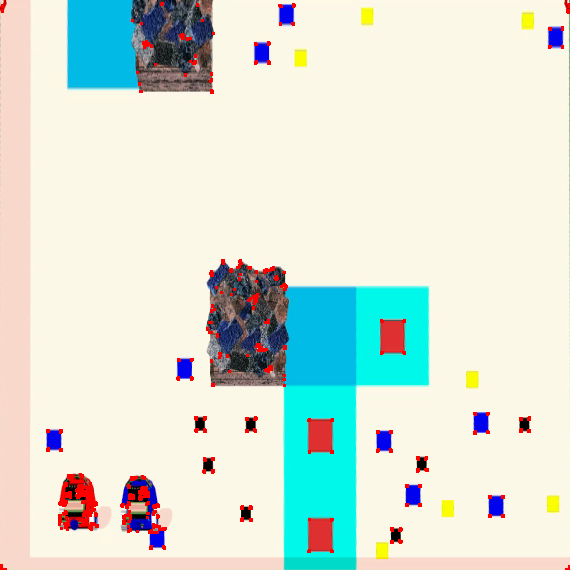

In [240]:
"Corner detection"
img=frame.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[255,0,0]
showarray(img)

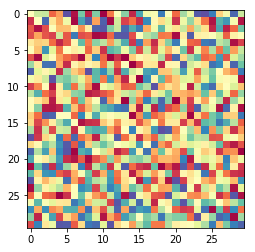

In [29]:
%matplotlib inline
from pylab import imshow, show, get_cmap
from numpy import random

Z = random.random((30, 30))   # Test data

imshow(Z, cmap=get_cmap("Spectral"), interpolation='nearest')
show()

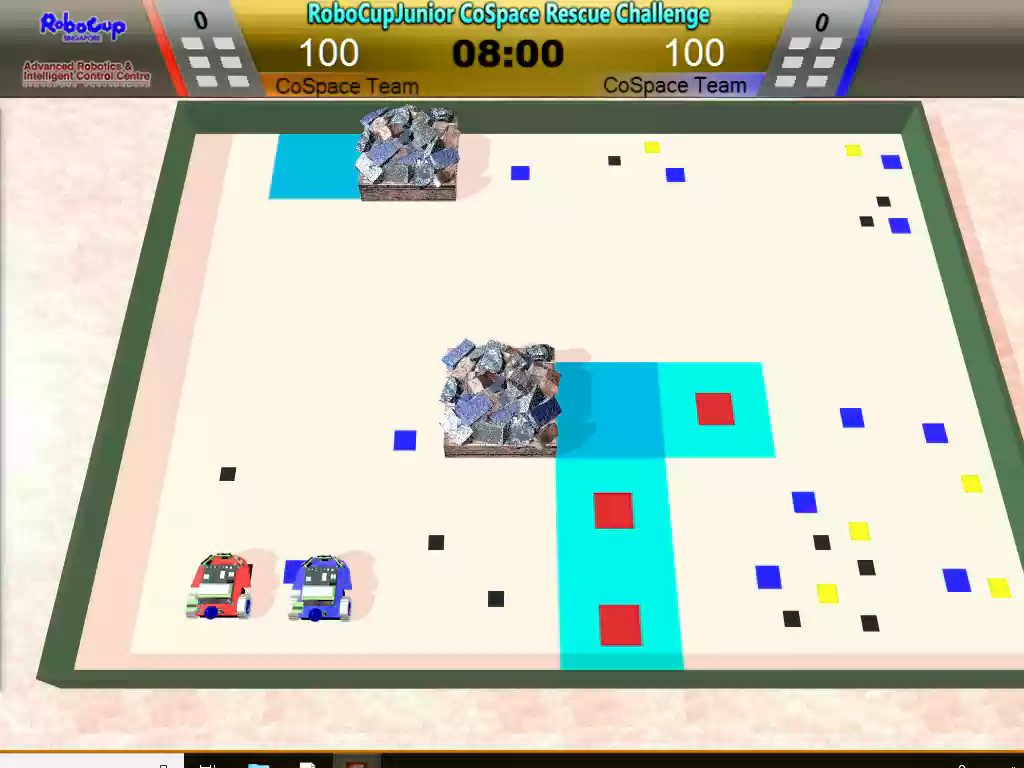

In [18]:
showarray(frame)

In [2]:
def showarray(a, fmt='png'):
    IPython.display.display(PIL.Image.fromarray(a))
    
def viz_box(src,cords,c=(255,0,0)):
    frame=src.copy()
    for i in cords:
        cv2.circle(frame,(i[0],i[1]), 5, c, -1)
    showarray(frame)
    
    
def get_color(frame,up,low):
    """
    Return Image mask of selected color range
    params:
        frame: opencv color src image
        up: [R,G,B] upper bound
        low: [R,G,B] Lower bound
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    #even though it says BGR treat it like RBG [r,g,b]
    upp_blue_Hsv=cv2.cvtColor(np.uint8([[up]]),cv2.COLOR_BGR2HSV).reshape(3,)
    low_blue_Hsv=cv2.cvtColor(np.uint8([[low]]),cv2.COLOR_BGR2HSV).reshape(3,)
    low_blue_Hsv[1]=60 # sets saturation

    mask = cv2.inRange(hsv, low_blue_Hsv, upp_blue_Hsv)

    res = cv2.bitwise_and(frame,frame,mask= mask) #apply mask
    return res,mask

def npwhere_toxyztupels(x,y,z):
    '''from np.where inices to x,y,z coordinates in the image'''
    
    if not (len(x)==len(y)==len(z)):
        raise ValueError("xyz MUST BE len(x)==len(y)==len(z)")
        
    r_tupels=[(x[i],y[i],z[i]) for i in range(len(x))]
    return r_tupels

def image_coordinates_to_ros(x,y):
    '''convert opencv/numpy image cooridnate frame to ROS cord frame (0,0) is bottom left'''
    return

def isWithinRange(x,y,r):
    if (x-y)>r or (y-x) >r:
        return False
    return True

def get_box_cords(frame,boxines_tolrance=7,box_min_area=50):
    ''' Get cordinates of objects 
    
        params:
         frame: numpy mask image of the desired object (returned by get_color()[1])
         boxines_tolrance: how much of a diff between w and h before we discard it as a triangle 
         box_min_area: min area of box
    '''
    r_ar=[]
    im2, contours, hierarchy = cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    i=0

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if not isWithinRange(w,h,boxines_tolrance) or cv2.contourArea(cnt)<box_min_area:
                continue
        #print("Object {0}:({1},{2}) w:{2} h:{3} ".format(i,x,y,w,h))
          
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        r_ar.append([cX,cY])
            
        i+=1
    return r_ar

def cam_norm(frame):
    pts1 = np.float32([pt_tl,pt_tr,pt_bl,pt_br])
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    
    M = cv2.getPerspectiveTransform(pts1,pts2)
    
    return cv2.warpPerspective(frame,M,(w,h))


def create_blank(width, height, rgb_color=(0, 0, 0)):
    """
    https://gist.github.com/navenduagarwal/95269ee19462e07edb2b4704116d0c5d
    Create new image(numpy array) filled with certain color in RGB
    """
    # Create black blank image
    image = np.zeros((height, width, 3), np.uint8)

    # Since OpenCV uses BGR, convert the color first
    color = tuple(reversed(rgb_color))
    # Fill image with color
    image[:] = color

    return image

def showcolors(up,low):
    #create_blank BGR not RGB
    up_img=create_blank(100,100,rgb_color=(up[2],up[1],up[0]))
    low_img=create_blank(100,100,rgb_color=(low[2],low[1],low[0]))
    showarray(np.vstack([up_img,low_img]))
